In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import os
import matplotlib.pyplot as plt
import geopandas as gpd
import descartes

### Mapping out the LDNe results 

In [96]:
world = gpd.read_file(
    gpd.datasets.get_path('naturalearth_lowres'))

In [97]:
Africa = gpd.read_file("map/Africa.dbf")

In [98]:
Africa.head()

,ID,CODE,COUNTRY,geometry
0,1,ALG,Algeria,"POLYGON ((-5.76362 25.58625, -5.84122 25.63542..."
1,2,ANG,Angola,"POLYGON ((13.36632 -8.32173, 13.36623 -8.32155..."
2,3,ANG,Angola,"POLYGON ((12.80576 -4.80649, 12.80092 -4.81917..."
3,4,ANG,Angola,"POLYGON ((11.76834 -16.79933, 11.76404 -16.799..."
4,5,ANG,Angola,"POLYGON ((12.89840 -5.98802, 12.89370 -5.98675..."


In [132]:
Ne_manifest = pd.read_csv("Ne_manifest.tsv", sep="\t")
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(Ne_manifest[['country', 'location', 'year','species_gambiae_coluzzii',
                         'counts', 'Ne_estimate', 'Jackknife_CI_lower', 'Jackknife_CI_upper']])

,country,location,year,species_gambiae_coluzzii,counts,Ne_estimate,Jackknife_CI_lower,Jackknife_CI_upper
0,Angola,Luanda,2009,coluzzii,81,190.4,110.4,519.7
1,Burkina Faso,Bana,2012,coluzzii,42,Infinite,Infinite,Infinite
2,Burkina Faso,Bana,2012,gambiae,22,2816.5,1980.7,4866.3
3,Burkina Faso,Pala,2012,coluzzii,11,Infinite,Infinite,Infinite
4,Burkina Faso,Pala,2012,gambiae,48,1698.3,745.4,Infinite
5,Burkina Faso,Souroukoudinga,2012,coluzzii,29,Infinite,Infinite,Infinite
6,Burkina Faso,Souroukoudinga,2012,gambiae,28,11545.1,5769.5,82678120.0
7,Burkina Faso,Bana,2014,coluzzii,47,Infinite,Infinite,Infinite
8,Burkina Faso,Bana,2014,gambiae,15,Infinite,Infinite,Infinite
9,Burkina Faso,Pala,2014,gambiae,16,102.7,47.3,Infinite


Filter out any infinite values, and change the Ne columns to float

In [133]:
infinite = Ne_manifest[Ne_manifest.Ne_estimate == 'Infinite']
infinite = infinite[infinite.sample_size > 15]

Ne_manifest = Ne_manifest[Ne_manifest.Ne_estimate != 'Infinite']
Ne_manifest['Ne_estimate'] = Ne_manifest.Ne_estimate.astype(float)
Ne_manifest['markersize'] = np.sqrt(Ne_manifest['Ne_estimate'])
Ne_manifest['markersize'] = Ne_manifest.markersize.clip(lower=1)

infinite['markersize'] = max(Ne_manifest['markersize'])

Ne_manifest = pd.concat([Ne_manifest, infinite])

In [134]:
Ne = gpd.GeoDataFrame(
    Ne_manifest, geometry=gpd.points_from_xy(Ne_manifest.longitude, Ne_manifest.latitude))
Ne.crs = "EPSG:4326"

In [135]:
Africa.crs = "EPSG:4326"

In [136]:
import json
from bokeh.io import show
import bokeh.plotting as bpl
from bokeh.palettes import Spectral6
from bokeh.plotting import figure, output_file, show
from bokeh.transform import linear_cmap
from bokeh.models import (CDSView, ColorBar, ColumnDataSource,
                          CustomJS, CustomJSFilter, 
                          GeoJSONDataSource, HoverTool,
                          LinearColorMapper, Slider)
from bokeh.layouts import column, row, widgetbox
from bokeh.palettes import brewer# Input GeoJSON source that contains features for plotting

Africa_geosource = GeoJSONDataSource(geojson = Africa.to_json())
Ne_geosource = GeoJSONDataSource(geojson = Ne.to_json())

In [137]:
mapper = linear_cmap(field_name='aim_fraction_colu', palette=Spectral6 ,
                     low=min(Ne['aim_fraction_colu']) ,
                     high=max(Ne['aim_fraction_colu']))

In [138]:
# Create figure object.
p = figure(title = 'LDNe estimates of effective population size in Ag1000g phase 3',
           plot_height = 1200,
           plot_width = 950, 
           toolbar_location = 'below',
           tools = "pan, wheel_zoom, box_zoom, reset",
          toolbar_sticky = False)

p.xgrid.grid_line_color = None
p.ygrid.grid_line_color = None # Add patch renderer to figure.

countries = p.patches('xs','ys', source = Africa_geosource,
                   fill_color = None,
                   line_color = 'gray', 
                   line_width = 0.5, 
                   fill_alpha = 1)# Create hover tool

ne_points = p.circle('x','y',source=Ne_geosource, fill_alpha=0.6, radius='markersize', color=mapper)

color_bar = ColorBar(color_mapper=mapper['transform'], width=8,  location=(0,0), title="Aim_fraction")
p.add_layout(color_bar, 'right')

In [139]:
p.add_tools(HoverTool(renderers = [ne_points],
                      tooltips = [('Country','@country'),
                                   ('Location', '@location'),
                                  ('Year', '@year'),
                                  ('Species', '@species_gambiae_coluzzii'),
                                   ('AIMs gambiae/coluzzii', '@aim_fraction_colu'),
                                  ('Ne','@Ne_estimate{0.00}'),
                                  ('Sample size', '@sample_size')]))
show(p)

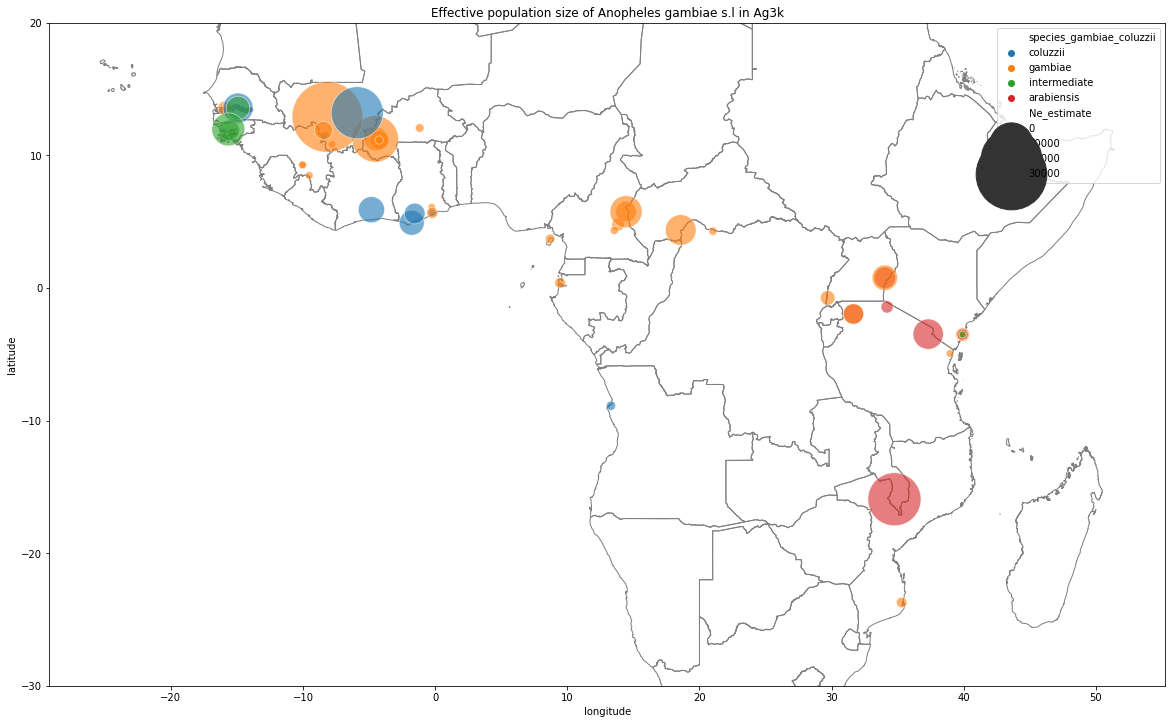

In [13]:
f, ax = plt.subplots(figsize=[20,20])
Africa.plot(ax=ax, color='none', edgecolor='grey')
sns.scatterplot(x=Ne['longitude'], y=Ne['latitude'], data=Ne, 
                size=Ne['Ne_estimate'], sizes=tuple([50,5000]),
                hue=Ne['species_gambiae_coluzzii'], alpha=0.6)
ax.set_ylim(-30, 20) # added/substracted value is to give some margin around total bounds
plt.title("Effective population size of Anopheles gambiae s.l in Ag3k")
plt.savefig("Effective population size of Ag1000g Phase 3 populations")
plt.show()